# PROJECT
DATA

In [40]:
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.nn.utils import spectral_norm
%matplotlib inline

In [41]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [31]:
data_path = '/content/gdrive/My Drive/project/pokemon/pokemon data/Data'
results_path = "/content/gdrive/My Drive/project/pokemon/dcgan/pokemon results 14000"
checkpoint_path_generator='/content/gdrive/My Drive/project/pokemon/dcgan/pokemon weights 14000/generator {} Epoch.pth'
checkpoint_path_discriminator='/content/gdrive/My Drive/project/pokemon/dcgan/pokemon weights 14000/discriminator {} Epoch.pth'

In [32]:
image_size = 64
batch_size = 64
normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # Convert channels from [0, 1] to [-1, 1] -> (img - 0.5)/0.5 for each channel

In [34]:
dataset = ImageFolder(data_path, transform=T.Compose([
    T.Resize((image_size,image_size)),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))
dataset

Dataset ImageFolder
    Number of datapoints: 14774
    Root location: /content/gdrive/My Drive/project/pokemon/pokemon data/Data
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [42]:
dataset = ConcatDataset([dataset])
dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=0, pin_memory=False)

Since these images have been normalized to [-1, 1],  we need to denormalize them in order to view them. Below is a denormalization function to do just that.

In [43]:
def denorm(image):
    return image * 0.5 +0.5

Now let's show a sample batch of real Pokemon images

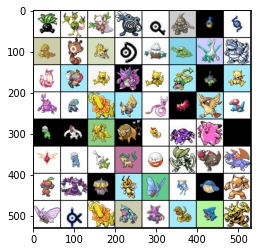

In [44]:
images, labels = next(iter(dataloader))
plt.imshow(make_grid(denorm(images), nrow=8).permute(1, 2, 0))

GPU setup

In [45]:
def get_training_device():
    # Use the GPU if possible
    if torch.cuda.is_available():
        return torch.device('cuda')
    # Otherwise use the CPU :-(
    return torch.device('cpu')

def to_device(data, device):
    # This moves the tensors to the device (GPU, CPU)
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

device = get_training_device()
device

device(type='cpu')

Now that we know the visualization works, we can continue with making the GAN. First, we'll start with the discriminator

Discriminator Model

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map,we could use maxpolling instead of stride .



In [46]:
Discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    spectral_norm(nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False)),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False)),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    spectral_norm(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False)),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    spectral_norm(nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False)),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    spectral_norm(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False)),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

Note that we're using the Leaky ReLU activation for the discriminator.

<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420">


>  Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.

LeakyReLU(x)=max(0,x)+negative_slope∗min(0,x)

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being real i.e. picked from the original dataset.



In [47]:
from torchsummary import summary
discriminator =  Discriminator
discriminator  = to_device(discriminator , device)
summary(discriminator, (3,image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
          Flatten-14                   

 Generator Model


The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape `(latent_size , 1, 1)` into an image tensor of shape `3 x image_size x image_size`. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a *transposed convolution* (also referred to as a *deconvolution*).

In [48]:
latent_size = 128
Generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [49]:
generator =  Generator
generator  = to_device(generator , device)
summary(generator, (latent_size,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,


This is to make sure everything is the correct size

torch.Size([8, 3, 64, 64])


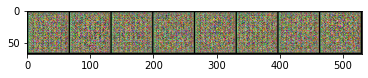

In [50]:
generator=Generator
fakePokemon = generator(torch.randn(8, latent_size, 1, 1,device=device)) # generator on 8 random noise vectors of shape latent_size,1,1
print(fakePokemon.shape) # return 8 images 
plt.imshow(make_grid(denorm(fakePokemon.cpu()), nrow=8).permute(1, 2, 0))

In [51]:
dev_dataloader = DeviceDataLoader(dataloader, device) # move the data to device

**Training Functions**

 Discriminator

In [52]:
def AddNoise(labels, prob): # create incorrect samples  
    num = int(prob * labels.shape[0])
    flipped = np.random.choice([i for i in range(labels.shape[0])], size=num)
    for i in flipped:
        labels[i] = 1 - labels[i]
    return labels


def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.randn(real_images.size(0), 1, device=device) * .15 + .85 #real target = 0.85 + gaussain noise N ~ (0,0.15^2) 
    real_targets = AddNoise(real_targets, .05) 
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.randn(fake_images.size(0), 1, device=device) * .15 + .15
    fake_targets = AddNoise(fake_targets, .05)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

Here are the steps involved in training the discriminator.

- We expect the discriminator to output 1 if the image was picked from the real  dataset, and 0 if it was generated using the generator network. 

- We first pass a batch of real images, and compute the loss, setting the target labels to 0.85 + gaussian noise (smoothing label). 

- Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0.15 + gaussian noise. 

- Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (`opt_d` only affects the `discriminator.parameters()`)

 Generator

In [17]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()



Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator. 

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.


Save Results

In [53]:
import os
from torchvision.utils import save_image
os.makedirs(results_path, exist_ok=True)

def SaveResults(index):

    # Generate fake pokemon
    vectors = torch.randn(64, latent_size, 1, 1, device=device) # 64 vectors of length latent_Size 
    FakePokemon = generator(vectors) # create 64  fake images
    
    # Make the filename for the output
    file = "{} Epoch .jpg".format(index)
    
    # Save the image
    save_image(denorm(FakePokemon), os.path.join(results_path, file), nrow=8) #saving 64 fake images as 8x8 grid - save_image is calling make_grid automaticlly
    print("Result Saved!")
    

 **Full Training**

## Full Training 

Let's define a `train` function to train the discriminator and generator  for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs.

<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>


In [54]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

SaveResults(0) #  EPOCH 0 before we trained the generator

def train(epochs, learning_rate, startIdx=1,
          checkpoint_path_generator = checkpoint_path_generator,
          checkpoint_path_discriminator=checkpoint_path_discriminator):
    # Empty the GPU cache to save some memory
    torch.cuda.empty_cache()
    
    # Track losses and scores
    disc_losses = []
    disc_scores = []
    gen_losses = []
    fake_scores = []
    
    # Create the optimizers
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    
    # Run the loop
    for epoch in range(epochs):
        # Go through each image
        for real_img, _ in tqdm(dev_dataloader):
            # Train the discriminator
            disc_loss, real_score, fake_score = train_discriminator(real_img, disc_optimizer)

            # Train the generator
            gen_loss = train_generator(gen_optimizer)
        
        # Collect results
        disc_losses.append(disc_loss)
        disc_scores.append(real_score)
        fake_scores.append(fake_score)
        gen_losses.append(gen_loss)
        
        # Print the losses and scores
        print("Epoch [{}/{}], gen_loss: {:.4f}, disc_loss: {:.4f}, real_score: {:.4f}, gen_score: {:.4f}".format(
            epoch+startIdx, epochs+startIdx-1, gen_loss, disc_loss, real_score, fake_score))
        if  (epoch + startIdx) % 5 == 0 :
            torch.save(generator.state_dict(), checkpoint_path_generator.format(epoch + startIdx))
            torch.save(discriminator.state_dict(), checkpoint_path_discriminator.format(epoch + startIdx))
        
        # Save the images and show the progress
        SaveResults(epoch + startIdx)
    
    # Return stats
    return disc_losses, disc_scores,fake_scores, gen_losses

Result Saved!


In [55]:
learning_rate = 0.0002
epochs = 100

In [56]:
# loading model weights :
def load_weights(n) :
  generator.load_state_dict(torch.load(checkpoint_path_generator.format(n),map_location=torch.device('cpu'))) 
  discriminator.load_state_dict(torch.load(checkpoint_path_discriminator.format(n),map_location=torch.device('cpu')))

In [ ]:
load_weights(150)
SaveResults(150)

Result Saved!


In [ ]:
history = train(epochs, learning_rate,startIdx = 150)

Results


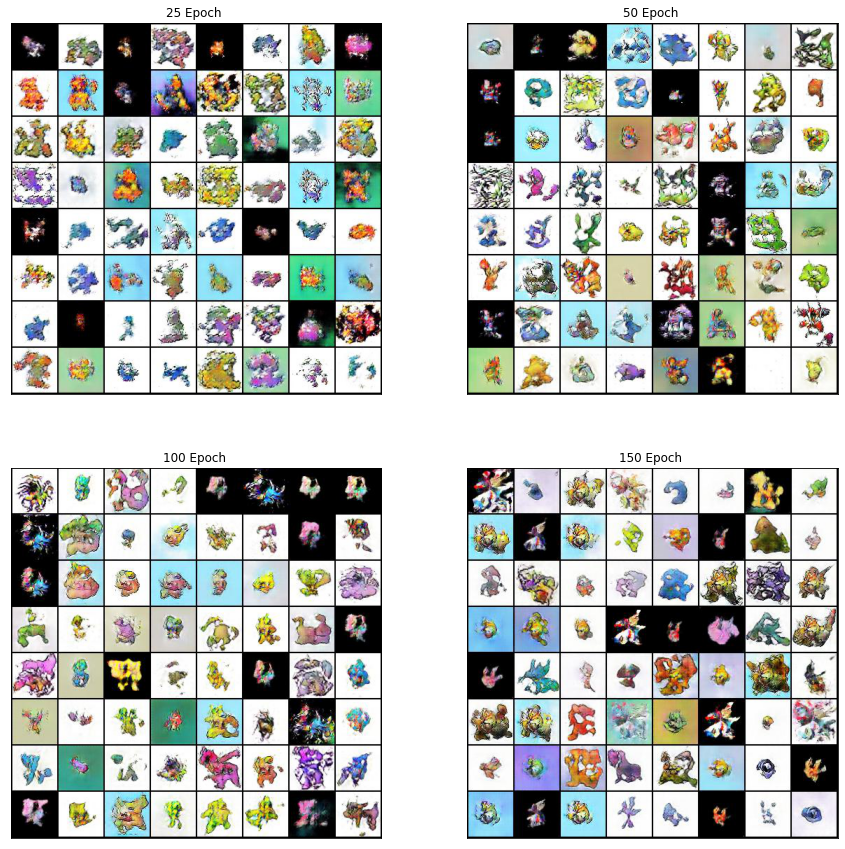

In [58]:
import matplotlib.pyplot as plt
def ShowResults(index) :
    image = []
    image.append(plt.imread(os.path.join(results_path,"{} Epoch .jpg".format(index[0]))))
    image.append(plt.imread(os.path.join(results_path,"{} Epoch .jpg".format(index[1]))))
    image.append(plt.imread(os.path.join(results_path,"{} Epoch .jpg".format(index[2]))))
    image.append(plt.imread(os.path.join(results_path,"{} Epoch .jpg".format(index[3]))))
    f, ax = plt.subplots(2,2,figsize=(15,15))
    ax[0,0].imshow(image[0])
    ax[0,1].imshow(image[1])
    ax[1,0].imshow(image[2])
    ax[1,1].imshow(image[3])
    ax[0,0].set_title("{} Epoch ".format(index[0]))
    ax[0,1].set_title("{} Epoch ".format(index[1]))
    ax[1,0].set_title("{} Epoch ".format(index[2]))
    ax[1,1].set_title("{} Epoch ".format(index[3]))
    ax[0,0].set_xticks([]); ax[0,0].set_yticks([])
    ax[0,1].set_xticks([]); ax[0,1].set_yticks([])
    ax[1,0].set_xticks([]); ax[1,0].set_yticks([])
    ax[1,1].set_xticks([]); ax[1,1].set_yticks([])
    plt.show()
    return image
image = ShowResults([25,50,100,150])

Lets create a short video of each epoch result

In [28]:
import cv2
import os

video_path = os.path.join(results_path,'RESULTS.avi')

files = [os.path.join(results_path, f) for f in os.listdir(results_path) if 'Epoch' in f]
files.sort(key=lambda fname: int(fname.split(results_path + '/')[1].split(' ')[0]))
out = cv2.VideoWriter(video_path,cv2.VideoWriter_fourcc(*'MP4V'), 5, (image[0].shape[0],image[0].shape[1]))
[out.write(cv2.imread(file)) for file in files]
out.release()

In [59]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp

Evaluate the Generator  with FID metric

In [60]:
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)
 
 # calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
 
def EvaluateFidScore(RealPokemon) :
    vectors = torch.randn(128, latent_size, 1, 1, device=device) # 128 vectors of length latent_Size 
    FakePokemon = generator(vectors) # create 128  fake images
    images1 = RealPokemon.transpose(1,3).detach().numpy()
    images2 = FakePokemon.transpose(1,3).detach().numpy()

    # prepare the inception v3 model
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

    shuffle(images1)
    print('Loaded', images1.shape, images2.shape)
    # convert integer to floating point values
    images1 = images1.astype('float32')
    images2 = images2.astype('float32')
    # resize images
    images1 = scale_images(images1, (299,299,3))
    images2 = scale_images(images2, (299,299,3))
    print('Scaled', images1.shape, images2.shape)
    # calculate fid
    fid = calculate_fid(model, images1, images2)
    print('FID: %.3f' % fid)
    return fid

Evaluate The Generator with Inception Score

In [61]:
def calculate_inception_score(images, n_split=10, eps=1E-16):
	# load inception v3 model
	model = InceptionV3()
	# enumerate splits of images/predictions
	scores = list()
	n_part = floor(images.shape[0] / n_split)
	for i in range(n_split):
		# retrieve images
		ix_start, ix_end = i * n_part, (i+1) * n_part
		subset = images[ix_start:ix_end]
		# convert from uint8 to float32
		subset = subset.astype('float32')
		# scale images to the required size
		subset = scale_images(subset, (299,299,3))	
		# predict p(y|x)
		p_yx = model.predict(subset)
		# calculate p(y)
		p_y = expand_dims(p_yx.mean(axis=0), 0)
		# calculate KL divergence using log probabilities
		kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
		# sum over classes
		sum_kl_d = kl_d.sum(axis=1)
		# average over images
		avg_kl_d = mean(sum_kl_d)
		# undo the log
		is_score = exp(avg_kl_d)
		# store
		scores.append(is_score)
	# average across images
	is_avg, is_std = mean(scores), std(scores)
	return is_avg, is_std
  
def EvaluteIS() :
	vectors = torch.randn(128, latent_size, 1, 1, device=device) # 64 vectors of length latent_Size 
	FakePokemon = generator(vectors) # create 128  fake images
	images = FakePokemon.transpose(1,3).detach().numpy()
	print('loaded', images.shape)
	# calculate inception score
	is_avg, is_std = calculate_inception_score(images)
	print('score', is_avg, is_std)
	return is_avg,is_std

		 

In [62]:
dataloader = DataLoader(dataset, 128, shuffle=True, num_workers=0, pin_memory=False)
RealPokemon, labels = next(iter(dataloader)) # 128 real pokemon images from the data

In [71]:
calculate_inception_score(RealPokemon.transpose(1,3).detach().numpy())

(2.8196936, 0.55222446)

In [63]:
FID = []
IS = []
for k in range (5,150,5) :
  generator.load_state_dict(torch.load(checkpoint_path_generator.format(k),map_location=torch.device('cpu'))) #loading the generator weight from k epoch
  fid = EvaluateFidScore(RealPokemon)
  iss = EvaluteIS()
  IS.append(iss)
  FID.append(fid)

87924736/87910968 [==============================] - 1s 0us/step
Loaded (128, 64, 64, 3) (128, 64, 64, 3)
Scaled (128, 299, 299, 3) (128, 299, 299, 3)
FID: 325.892
loaded (128, 64, 64, 3)
96124928/96112376 [==============================] - 1s 0us/step
score 2.3361337 0.27298474
Loaded (128, 64, 64, 3) (128, 64, 64, 3)
Scaled (128, 299, 299, 3) (128, 299, 299, 3)
FID: 282.654
loaded (128, 64, 64, 3)
score 2.1534123 0.17405038
Loaded (128, 64, 64, 3) (128, 64, 64, 3)
Scaled (128, 299, 299, 3) (128, 299, 299, 3)
FID: 267.415
loaded (128, 64, 64, 3)
score 2.347814 0.24275245
Loaded (128, 64, 64, 3) (128, 64, 64, 3)
Scaled (128, 299, 299, 3) (128, 299, 299, 3)
FID: 264.273
loaded (128, 64, 64, 3)
score 2.6335979 0.24786653
Loaded (128, 64, 64, 3) (128, 64, 64, 3)
Scaled (128, 299, 299, 3) (128, 299, 299, 3)
FID: 237.168
loaded (128, 64, 64, 3)
score 2.5936852 0.36511302
Loaded (128, 64, 64, 3) (128, 64, 64, 3)
Scaled (128, 299, 299, 3) (128, 299, 299, 3)
FID: 236.016
loaded (128, 64, 64, 3

 Performance Analysis

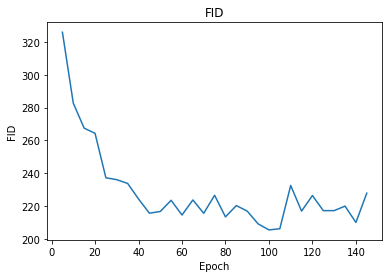

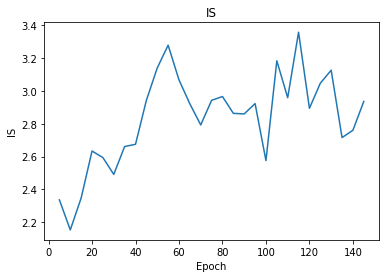

In [70]:
IS = [I[0] for I in IS]
def plot_learning_curve(FID,IS):
    i = range(5,150,5)
    plt.plot(i,FID)
    plt.xlabel('Epoch')
    plt.ylabel('FID')
    plt.title('FID')
    plt.show()

    plt.plot(i,IS)
    plt.xlabel('Epoch')
    plt.ylabel('IS')
    plt.title('IS')
    plt.show()
  
plot_learning_curve(FID,IS)

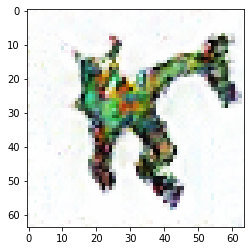

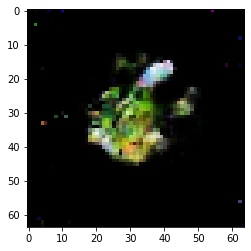

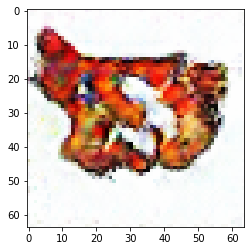

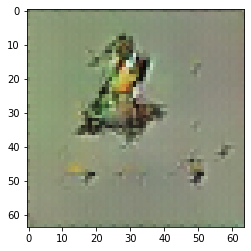

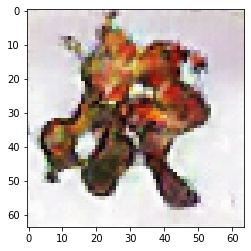

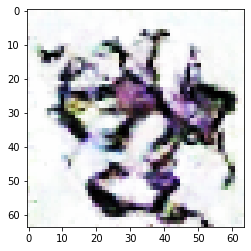

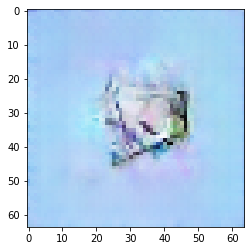

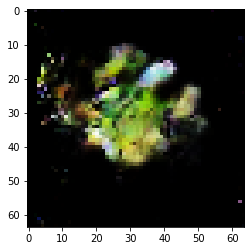

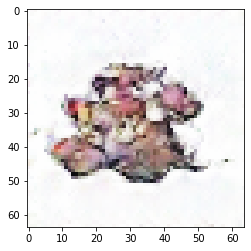

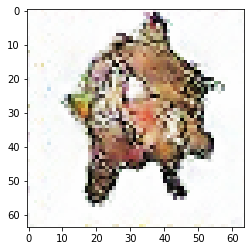

In [76]:
coolImages = generator(torch.randn(10, latent_size, 1, 1, device=device))
for img in coolImages:
  plt.imshow(denorm(img.permute(1, 2, 0)).detach().numpy())
  plt.show()